Adapted from https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

Info on Seaborn and Matplotlib color palettes:  https://seaborn.pydata.org/tutorial/color_palettes.html

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
sns.set()
from matplotlib import pyplot as plt

In [37]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(138, 290, s=40, l=50, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

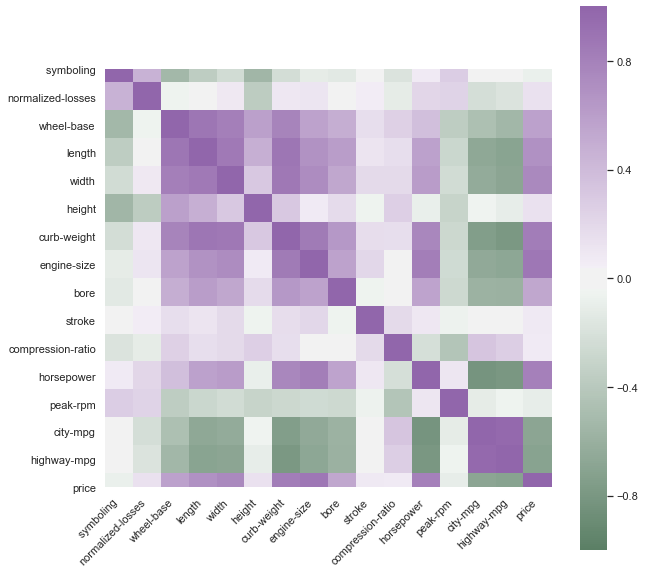

In [38]:
%matplotlib inline
data = pd.read_csv('https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv')

corr = data.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(138, 290, s=40, l=50, n=256),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

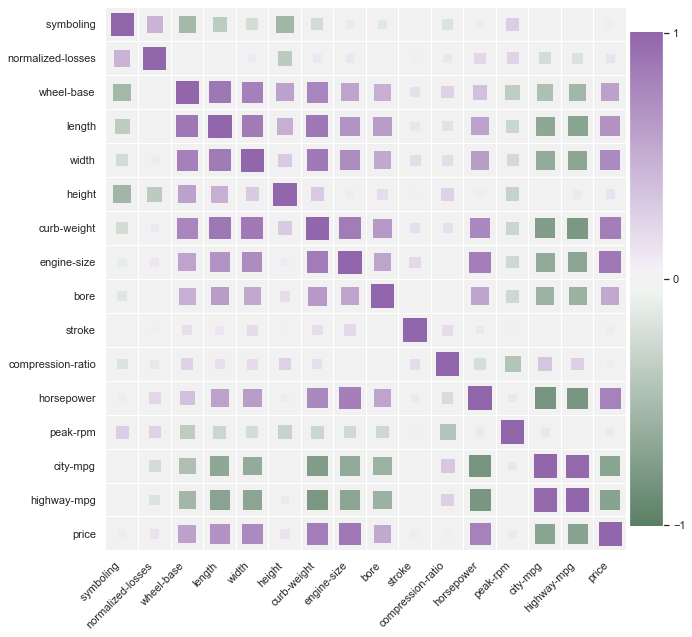

In [39]:
plt.figure(figsize=(10, 10))
corrplot(corr)

TypeError: light_palette() got an unexpected keyword argument 'n'

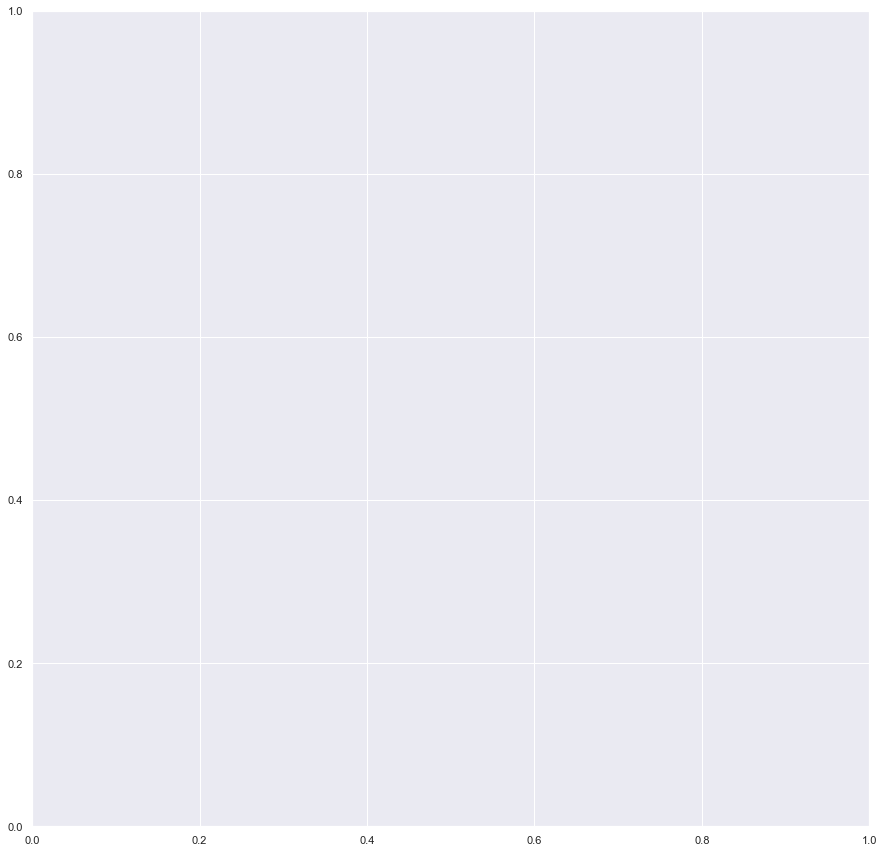

In [50]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.light_palette("green", n=256, reverse=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})